## Workshop 2: Extreme Precipitation Statistics 

<img src="../images/partners.png" width="50%"/>


The learning objectives of this workshop are to understand:
1. The retrieval of precipitation data through the Google Earth Engine API.
2. The subsetting of data to a region of interest.
3. The processing of precipitation data to annual maxima over the region of interest.
4. Fitting of data to a Gumbel distribution for extreme value analysis.
5. Creation of the Gumbel plot.

#### It is strongly encouraged to change any part of this notebook, for instance the region of interest, time period, data layers.

## Importing Google Earth Engine API
See the GEE.ipynb script for more information.

In [1]:
import ee
ee.Authenticate()

True

Authenticate using ee: 
- This command will open a new window asking you to sign in with your Google Account.
- Then you will have to enable permissions for the notebook to access your Google Account.
- The authentication flow will generate a token which you will need to provide in a pop-up box.
- The token will be saved and valid for a week.

In [2]:
# Initialize your project, using the project ID you took note of during
# the creation of your Google Earth Engine Project
projectID = 'ee-hkvdeveloper'
ee.Initialize(project=projectID)

Now that you are authenticated and have initialized your project we are able to use Google Earth Engine API.

## Import Python packages

In [5]:
import geemap
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r

If the packages are not already installed, run:\
!pip install earthengine-api geemap numpy matplotlib scipy

## Subsetting the data

Here, we define the function that allows us to subset the data to a region of interest.

In [6]:
# The following function creates a bounding box (Region of Interest) based on given Latitude/Longitude
# This is handy so we can limit the amount of data we retrieve and display

def create_bounding_box(center_lat, center_lon, width, height):
    # Calculate half-width and half-height
    half_width = width / 2
    half_height = height / 2

    # Define the bounding box coordinates
    bounding_box = [
        [center_lon - half_width, center_lat - half_height],  # Lower-left corner
        [center_lon - half_width, center_lat + half_height],  # Upper-left corner
        [center_lon + half_width, center_lat + half_height],  # Upper-right corner
        [center_lon + half_width, center_lat - half_height],  # Lower-right corner
        [center_lon - half_width, center_lat - half_height],  # Closing the polygon
    ]

    return ee.Geometry.Polygon(bounding_box, None, False)

### Specify region of interest, time period, precipitation dataset

Now, we specify the parameters of interest for subsetting the data.

In [7]:
# Feel free to change to another region of interest (roi)
center_latitude = -18.665695
center_longitude = 35.529564
width = 5 # in degrees
height = 5 # in degrees

# Note that the bounding box can also be created using min/max latlons

# Create the bounding box
roi = create_bounding_box(center_latitude, center_longitude, width, height)

# Define the time period
start_year = 1991
end_year = 2021

# Load CHRIPS precipitation dataset
# Feel free to change to another dataset
chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY').filterDate(ee.Date(start_year), ee.Date(end_year)).select('precipitation')

# Clip the dataset to the region of interest
chirps_roi = chirps.map(lambda img: img.clip(roi))

## Visualize the data

First, we visualize the dataset using the geemap package. It is recommended to perform a visualization step before subsetting the data. 

In [8]:
# Create a Map and add the precipitation layer
Map = geemap.Map()
# Center the map based on the region of interest
Map.centerObject(roi, 10)
# Add the CHIRPS precipitation layer and assign a style
Map.addLayer(chirps_roi, {
    'min': 0,
    'max': 20,
    'opacity': 0.5,
    'palette': ['white', 'blue']
}, 'Mean Precipitation')
Map.addLayerControl()
Map

Map(center=[-18.658919111911636, 35.52956399999995], controls=(WidgetControl(options=['position', 'transparent…

The map shows that we selected the region of interest from the CHIRPS dataset.

## Retrieve and Process CHIRPS Precipitation Data
Here, we combine the previous steps to:
1. Retrieve CHIRPS data.
2. Subset CHIRPS data.
3. Calculate annual maximum over region of interest.

In [9]:
# Loop between start_year and end_year
yearly_max = []
for year in range(start_year, end_year):  # Example: 1981 to 2020
    print(f'Processing year: {year}', end='\r')

    # Specify start_date and end_date per year
    start_date = f'{year}-01-01'
    end_date = f'{year}-12-31'

    # Retrieve CHIRPS data through Google Earth Engine API
    chirps = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY')\
                .filterDate(ee.Date(start_date), ee.Date(end_date))\
                .select('precipitation')
    
    # Get the maximum value for the year
    max_image = chirps.max()

    # Reduce the region to the region of interest
    max_value = max_image.reduceRegion(ee.Reducer.max(), roi, 1000).get('precipitation').getInfo()

    # Append the output to list
    yearly_max.append(max_value)

The annual daily precipitation maxima are collected and stored in the yearly_max variable.

## Extreme value analysis

The next step is to calculate the extreme value statistics by fitting adistribution through the annual daily precipitation maxima. We will use the Gumbel distribution, other types of distributions are possible:

![Create a Project](images/extreme_value_analysis.png)
Source: Huyse & Thacker, 2004


## Fitting Data to a Gumbel Distribution

Here, we fit the Gumbel Distribution through the data.

In [10]:
# Fit the Gumbel distribution to the data
params = gumbel_r.fit(yearly_max)
location, scale = params

## Visualize results

The final step is to visualize the results in the form of a Gumbel plot.

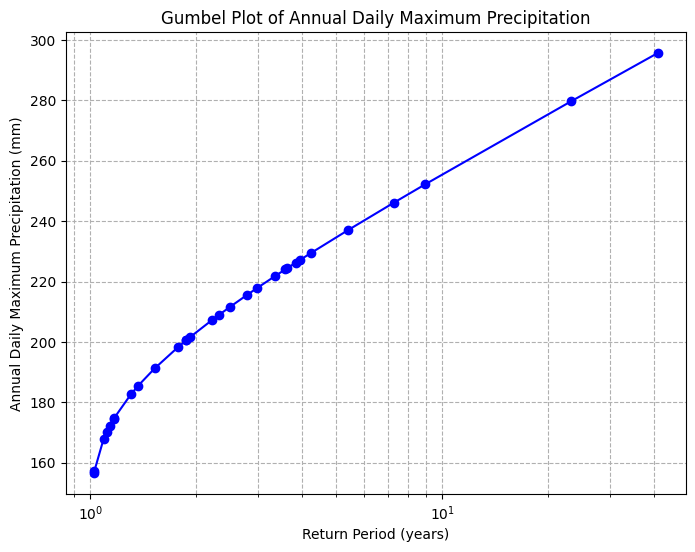

In [11]:
# Calculate the CDF for the annual daily maximum precipitation values
cdf_values = gumbel_r.cdf(yearly_max, *params)

# Calculate return periods from the CDF values
return_periods = 1 / (1 - cdf_values)

# Sort the data for plotting (important for line plots to make sense)
sorted_indices = np.argsort(return_periods)
sorted_return_periods = return_periods[sorted_indices]
sorted_yearly_max = np.array(yearly_max)[sorted_indices]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(sorted_return_periods, sorted_yearly_max, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Optional: Logarithmic scale can make the plot easier to interpret
plt.xlabel('Return Period (years)')
plt.ylabel('Annual Daily Maximum Precipitation (mm)')
plt.title('Gumbel Plot of Annual Daily Maximum Precipitation')
plt.grid(True, which="both", ls="--")
plt.show()

## You have sucessfully created an extreme value analysis of the occurence of Annual Daily Maximum Precpitation!

Please try to:
- Select different region of interest and compare the results.
- Select different precipitation dataset and compare the results.
- Extrapolate Gumbel plot for higher Return Periods.
- Apply a different fit such as Generalized extreme value distribution (GEV).